In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from scikitplot.metrics import plot_roc
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
import numpy as np
from tqdm import tqdm
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification

In [32]:
def plot_ROC_comparison(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
    plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

In [33]:
df = pd.read_csv(r"\final_clean_dataset.csv")
df_j = df.copy() # Deep copy

In [34]:
# These are the classes that I want to join
target_genres = ['j-idol', 'j-dance', 'anime', 'j-pop'] # J-songs
# Create the 'target' column in df_j; if the song belongs to target_genres the value is 1
df_j['j-songs'] = df['genre'].apply(lambda x: 1 if x in target_genres else 0)

### Data preparation

In [35]:
# I removed part of the variables
X = df_j[['duration_ms', 'popularity', 'danceability',
       'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence',
       'time_signature', 'n_beats', 'fade_out_duration',
       'primary_artist_popularity', 'average_artists_popularity',
       'sum_of_followers', 'explicit']].values
y = np.array(df_j['j-songs'])
#removed: album_total_tracks, id, name, primary_artist_id, other_artists_id, album_release_date, album_name, genre, artist

In [36]:
ctr = Counter(y)
ctr
# The class that we want to predict is 1 (4%)
# the class 0 represents all the other genres (96%); total tracks 88284

Counter({0: 84340, 1: 3660})

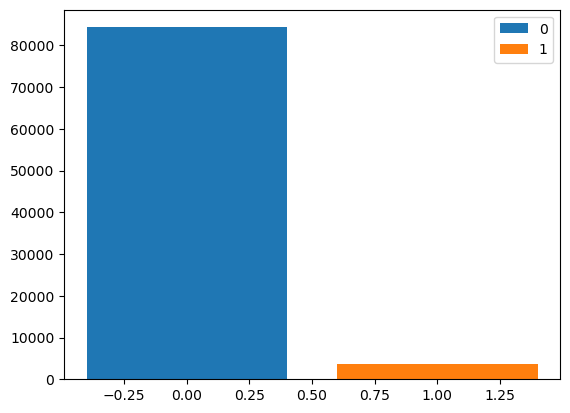

In [37]:
plt.bar(ctr.keys(), ctr.values(), label=ctr.keys(), color=['tab:blue', 'tab:orange'])
plt.legend()
plt.show()

## Classification

Decision Tree without any RS, CV and other hyper-parameters tuning

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     25324
           1       0.42      0.38      0.40      1076

    accuracy                           0.95     26400
   macro avg       0.70      0.68      0.69     26400
weighted avg       0.95      0.95      0.95     26400



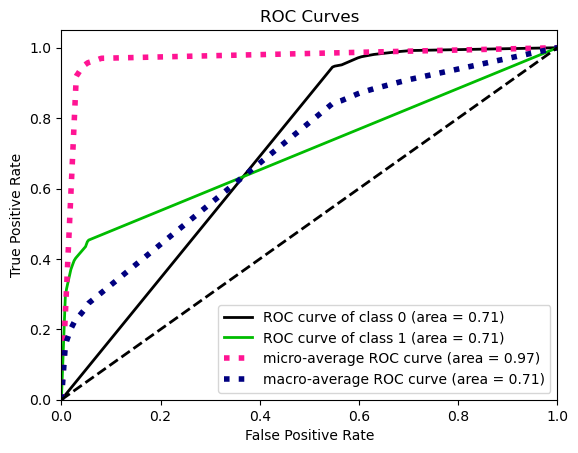

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print(classification_report(y_test, y_pred0))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

In [9]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train.T[0].reshape(-1,1), y_train)
y_pred = clf.predict(X_test.T[0].reshape(-1,1))
print(classification_report(y_test, y_pred,zero_division=0))

LogisticRegression(random_state=42)

In [ ]:
y_pred = clf.predict(X_test.T[0].reshape(-1,1))
print(classification_report(y_test, y_pred,zero_division=0))

In [40]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

Decision Tree with RS and CV

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10, 'splitter': 'best'}
Best F1-score: 0.6768557085245726
Accuracy 0.9527651515151515
F1-score [0.97544551 0.38114144]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     25324
           1       0.41      0.36      0.38      1076

    accuracy                           0.95     26400
   macro avg       0.69      0.67      0.68     26400
weighted avg       0.95      0.95      0.95     26400



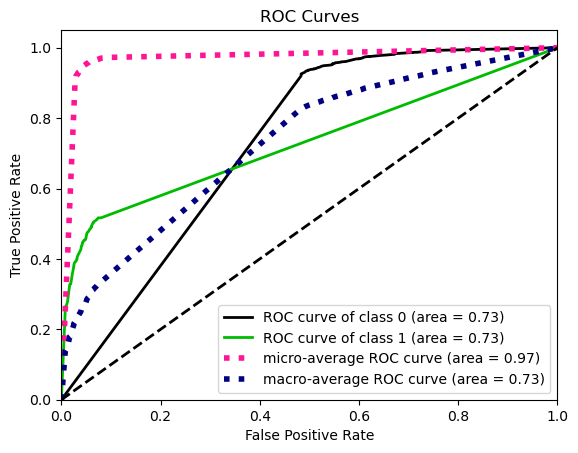

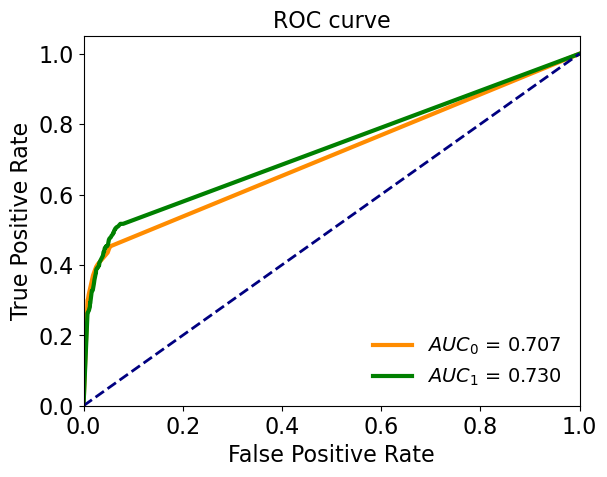

In [14]:
# Define the classifier
clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10]
}

# Define the scoring function
scorer = make_scorer(f1_score, average='macro')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get the best model
best_clf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Print evaluation metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# Plot ROC curve
y_score = best_clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# Plot ROC comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr,tpr)

Class   precision recall  f1-score   support
0       0.97      0.98      0.98     25324
1       0.42      0.38      0.40      1076

Class   precision recall  f1-score   support
  0       0.97      0.98      0.98     2532   1       0.41      0.36      0.38      1076




#### PCA for Visualization

In [15]:
scl = StandardScaler()
X_pca= scl.fit_transform(X)

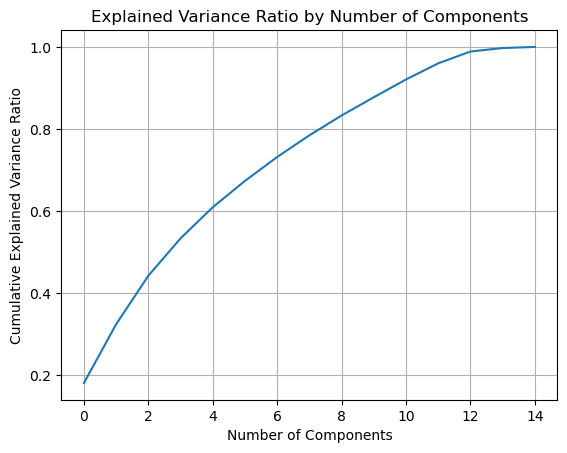

In [16]:
# Fit PCA with a range of components
pca = PCA()
pca.fit(X_pca)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

In [17]:
pca = PCA(n_components=7)
X_reduced = pca.fit_transform(X_pca)
pca_df = pd.DataFrame(X_reduced)

In [18]:
pca_df['class']= df_j['j-songs']

In [19]:
pca_df['class'].value_counts()

class
0    84340
1     3660
Name: count, dtype: int64

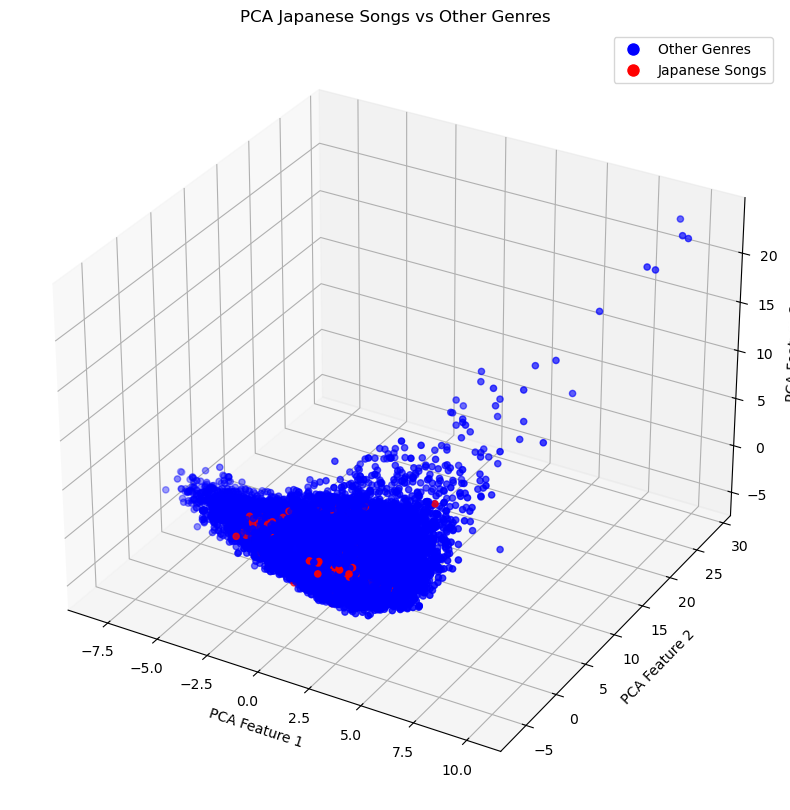

In [20]:
# Assuming 'pca_df' is a DataFrame with PCA components and 'outliers' column as labels
labels = pca_df['class']

# Create the 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data
scatter = ax.scatter(pca_df[0], pca_df[1], pca_df[2], c=labels, cmap='bwr', s=20)

# Set the title and labels
ax.set_title('PCA Japanese Songs vs Other Genres')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')

# Create a legend
normal = plt.Line2D([0], [0], marker='o', color='w', label='Other Genres',
                    markerfacecolor='b', markersize=10)
outlier = plt.Line2D([0], [0], marker='o', color='w', label='Japanese Songs',
                     markerfacecolor='r', markersize=10)
ax.legend(handles=[normal, outlier])

# Show the plot
plt.show()

## Undersampling

### Random Undersampling

In [12]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 2584, 1: 2584})


In [21]:
from sklearn.metrics import precision_score


In [22]:
acc = []
for i in range(4, len(X_res.T)):
    clf = LogisticRegression(random_state=42)
    clf.fit(X_res.T[i].reshape(-1,1), y_res)
    y_pred = clf.predict(X_test.T[i].reshape(-1,1))
    #print(classification_report(y_test, y_pred,zero_division=0))
    acc.append(precision_score(y_test, y_pred))
acc

[0.06508450197770586,
 0.04673730072284384,
 0.03733784545967287,
 0.05061514325819503,
 0.04205374917053749,
 0.03753196930946292,
 0.042075608869502,
 0.040653008962868116,
 0.04058287795992714,
 0.0,
 0.056797853309481214]

In [27]:
unique_classes, counts = np.unique(y_test, return_counts=True)

# Print the results
print("Unique Classes:", unique_classes)
print("Counts:", counts)

Unique Classes: [0 1]
Counts: [25324  1076]


              precision    recall  f1-score   support

           0       0.98      0.72      0.83     25324
           1       0.10      0.71      0.17      1076

    accuracy                           0.72     26400
   macro avg       0.54      0.71      0.50     26400
weighted avg       0.95      0.72      0.80     26400



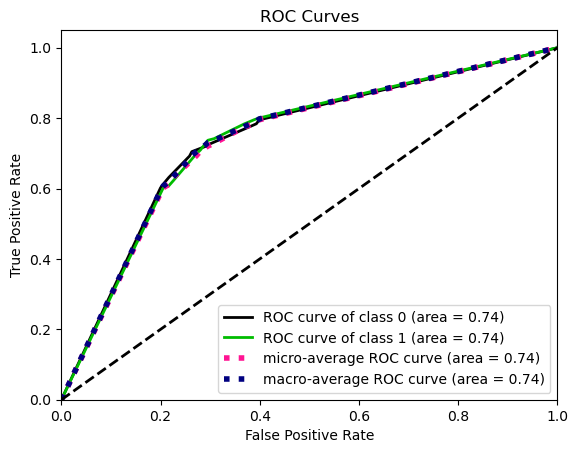

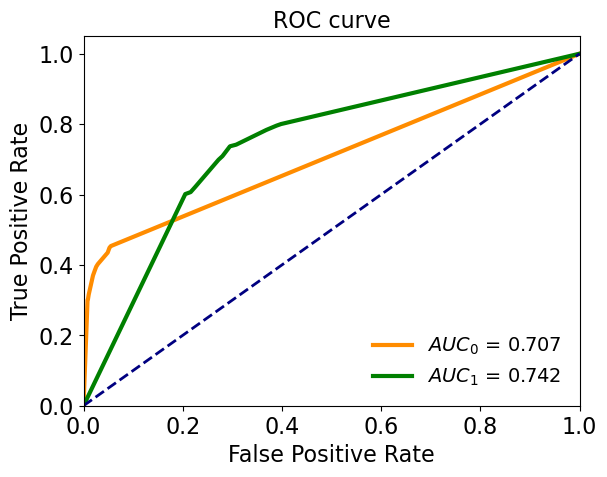

In [24]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

In [44]:
# Define the parameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],  # Split quality criterion
    'splitter': ['best', 'random'],    # Strategy used to split at each node
    'max_depth': [None] + list(np.arange(1, 20)),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 20),   # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Assuming X_res and y_res are already defined
# Fit the random search model
random_search.fit(X_res, y_res)

# Print the best parameters found by the random search
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'splitter': 'best', 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 13, 'criterion': 'gini'}


              precision    recall  f1-score   support

           0       0.98      0.72      0.83     25324
           1       0.10      0.70      0.17      1076

    accuracy                           0.72     26400
   macro avg       0.54      0.71      0.50     26400
weighted avg       0.95      0.72      0.81     26400



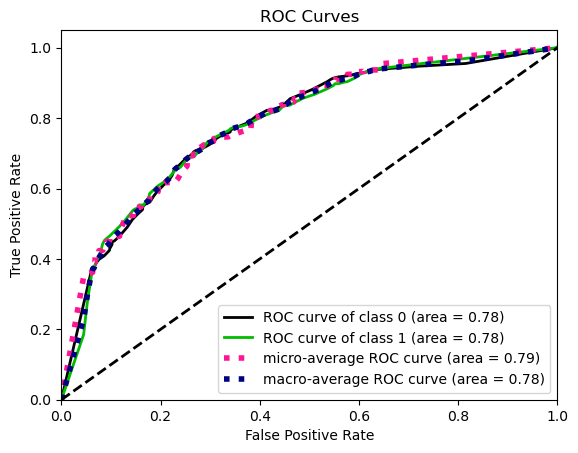

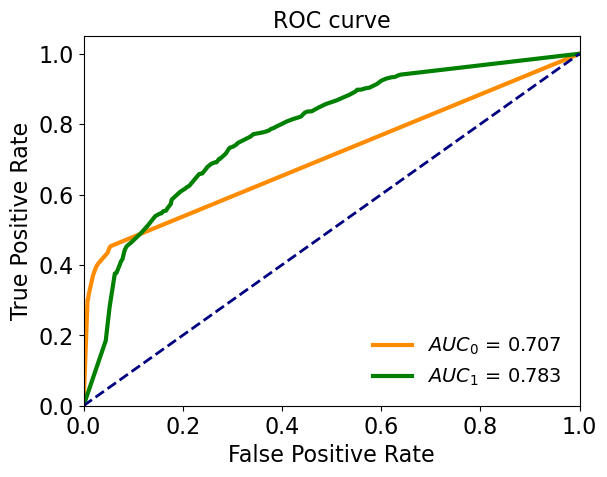

In [25]:
# Define the classifier with the specified parameters
clf = DecisionTreeClassifier(
    min_samples_split=19, 
    min_samples_leaf=5, 
    max_features=None, 
    max_depth=13, 
    criterion='gini',
)

# Fit the classifier on the training data
clf.fit(X_res, y_res)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

#### Cluster Centroid

In [25]:
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
X_res_CC, y_res_CC = cc.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_CC))

Resampled dataset shape Counter({0: 2584, 1: 2584})


In [28]:
from sklearn.metrics import recall_score

rcl = []
for i in range(4, len(X_res_CC.T)):
    clf = LogisticRegression(random_state=42)
    clf.fit(X_res_CC.T[i].reshape(-1,1), y_res_CC)
    y_pred = clf.predict(X_test.T[i].reshape(-1,1))
    #print(classification_report(y_test, y_pred,zero_division=0))
    rcl.append(recall_score(y_test, y_pred))
rcl

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

[0.3382899628252788,
 0.8782527881040892,
 0.6152416356877324,
 0.5669144981412639,
 0.9423791821561338,
 0.5455390334572491,
 0.41356877323420077,
 0.4721189591078067,
 0.5176579925650557,
 0.0,
 0.11802973977695168]

              precision    recall  f1-score   support

           0       0.97      0.09      0.16     25324
           1       0.04      0.94      0.08      1076

    accuracy                           0.12     26400
   macro avg       0.51      0.52      0.12     26400
weighted avg       0.93      0.12      0.16     26400



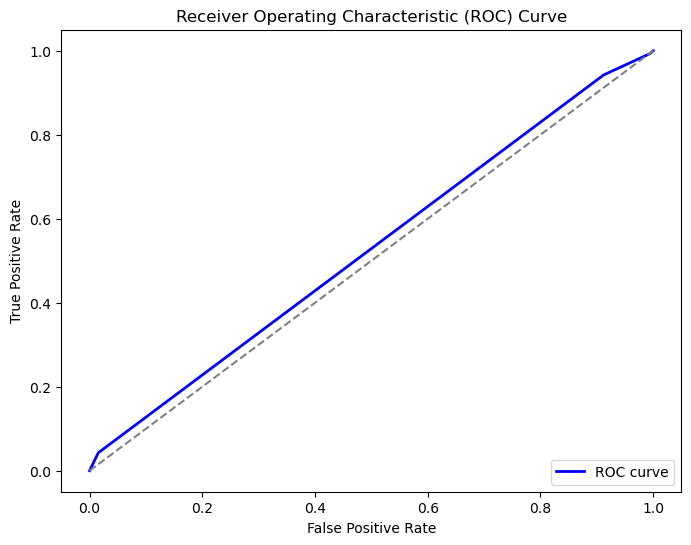

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve
import matplotlib.pyplot as plt

# Assuming X_res_CC, y_res_CC, X_test, y_test are defined
# Replace with your actual data

# Train logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_res_CC[:, [8]], y_res_CC)  # Ensure X_res_CC[:, [8]] selects the 8th feature

# Predict on test data
y_pred = clf.predict(X_test[:, [8]])

# Print classification report
print(classification_report(y_test, y_pred, zero_division=0))

# ROC curve
y_score = clf.predict_proba(X_test[:, [8]])
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [38]:
scl = StandardScaler()
X_pca_CC= scl.fit_transform(X_res_CC)

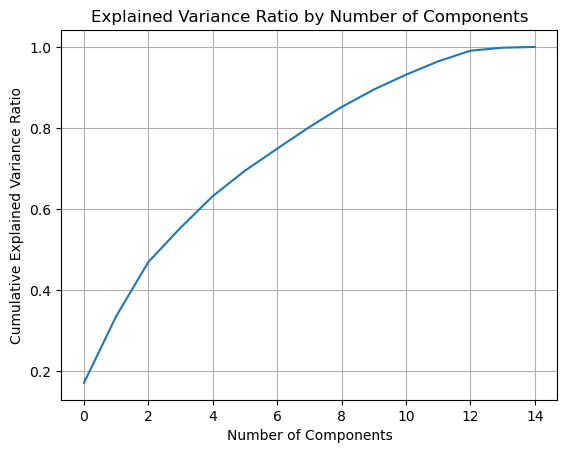

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA with a range of components
pca = PCA()
pca.fit(X_pca_CC)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

In [46]:
pca_CC = PCA(n_components=7)
X_reduced_CC = pca_CC.fit_transform(X_pca_CC)
pca_df_CC = pd.DataFrame(X_reduced_CC)

In [48]:
pca_df_CC['class'] = y_res_CC

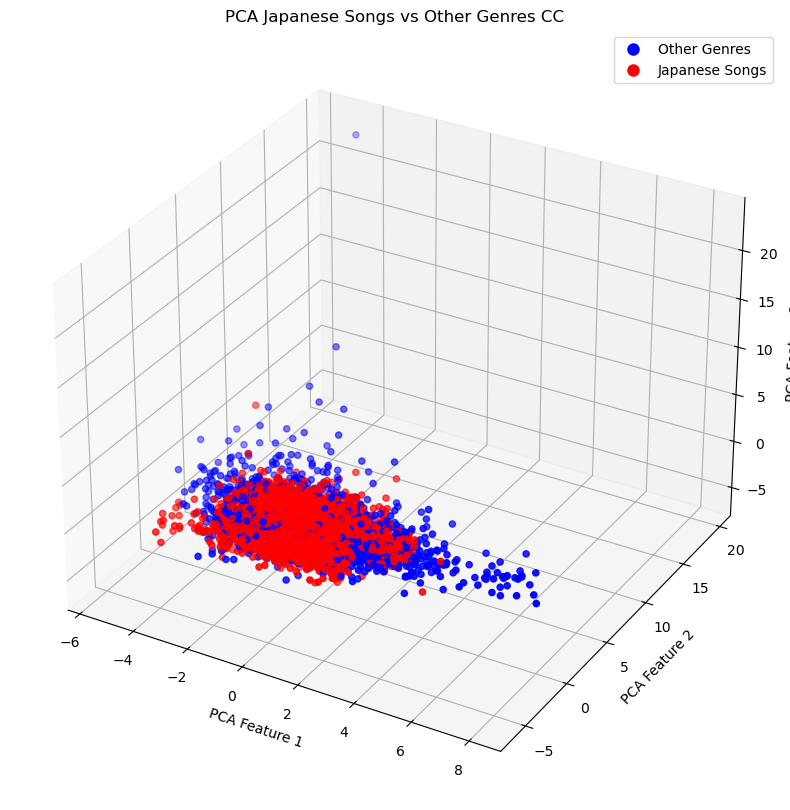

In [50]:
# Assuming 'pca_df' is a DataFrame with PCA components and 'outliers' column as labels
labels = pca_df_CC['class']

# Create the 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data
scatter = ax.scatter(pca_df_CC[0], pca_df_CC[1], pca_df_CC[2], c=labels, cmap='bwr', s=20)

# Set the title and labels
ax.set_title('PCA Japanese Songs vs Other Genres CC')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')

# Create a legend
normal = plt.Line2D([0], [0], marker='o', color='w', label='Other Genres',
                    markerfacecolor='b', markersize=10)
outlier = plt.Line2D([0], [0], marker='o', color='w', label='Japanese Songs',
                     markerfacecolor='r', markersize=10)
ax.legend(handles=[normal, outlier])

# Show the plot
plt.show()

In [30]:
# Define the parameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],  # Split quality criterion
    'splitter': ['best', 'random'],    # Strategy used to split at each node
    'max_depth': [None] + list(np.arange(1, 20)),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 20),   # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Assuming X_res and y_res are already defined
# Fit the random search model
random_search.fit(X_res_CC, y_res_CC)

# Print the best parameters found by the random search
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': None, 'max_depth': 19, 'criterion': 'gini'}


              precision    recall  f1-score   support

           0       0.98      0.45      0.62     25324
           1       0.06      0.84      0.11      1076

    accuracy                           0.47     26400
   macro avg       0.52      0.64      0.37     26400
weighted avg       0.95      0.47      0.60     26400



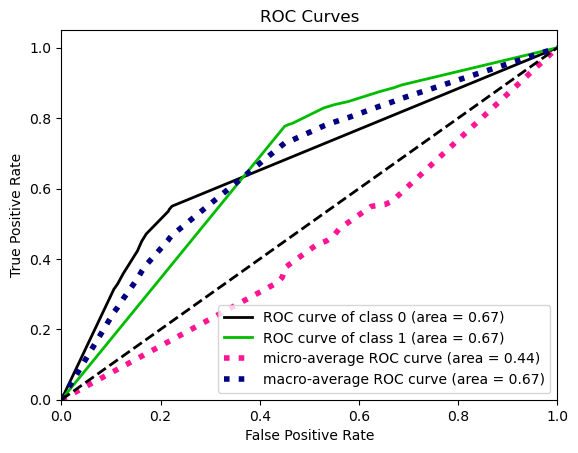

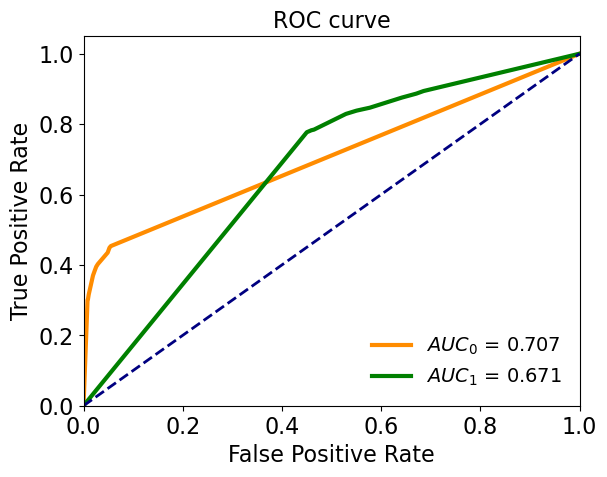

In [32]:
# fit
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)

clf.fit(X_res_CC, y_res_CC)

# predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

              precision    recall  f1-score   support

           0       0.98      0.45      0.62     25324
           1       0.06      0.83      0.11      1076

    accuracy                           0.47     26400
   macro avg       0.52      0.64      0.37     26400
weighted avg       0.95      0.47      0.60     26400



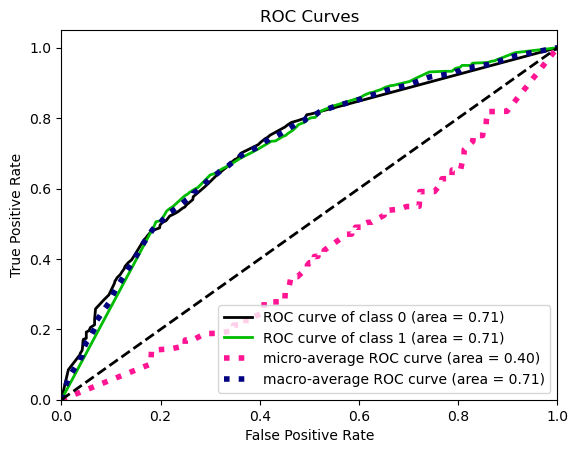

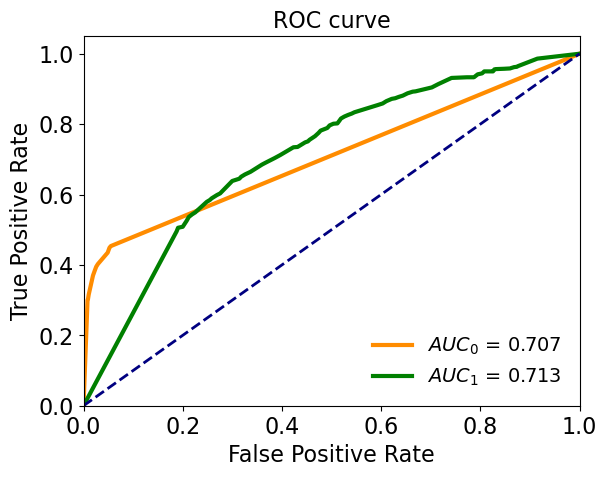

In [33]:
clf = DecisionTreeClassifier(
    min_samples_split=8, 
    min_samples_leaf=15, 
    max_features=None, 
    max_depth=13, 
    criterion='gini',
)
clf.fit(X_res_CC, y_res_CC)

# predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

#### Condensed Nearest Neighbour

In [51]:
# Initialize CNN
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

# Custom function to monitor progress
def fit_resample_with_progress(X, y, batch_size=1000):
    num_batches = int(np.ceil(len(X) / batch_size))
    X_res, y_res = [], []
    
    for i in tqdm(range(num_batches), desc="Resampling Progress"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X))
        
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        
        X_res_batch, y_res_batch = cnn.fit_resample(X_batch, y_batch)
        X_res.append(X_res_batch)
        y_res.append(y_res_batch)
    
    return np.vstack(X_res), np.hstack(y_res)

# Apply the custom function
X_res_CNN, y_res_CNN = fit_resample_with_progress(X_train, y_train)

# Print the resampled dataset shape
print('Resampled dataset shape %s' % Counter(y_res_CNN))


Resampling Progress: 100%|██████████| 62/62 [09:56<00:00,  9.62s/it]

Resampled dataset shape Counter({0: 8917, 1: 2584})


In [52]:
scl = StandardScaler()
X_pca_CNN= scl.fit_transform(X_res_CNN)

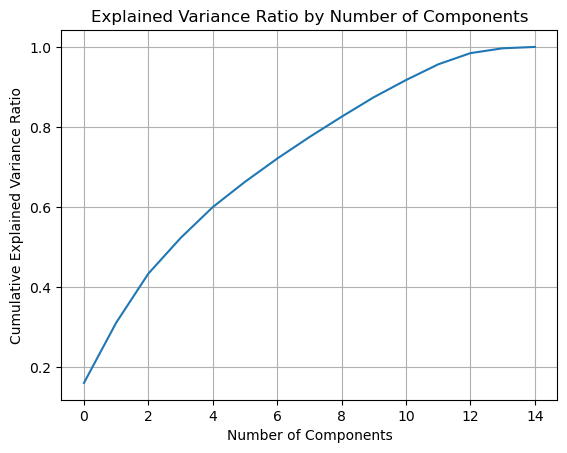

In [53]:
# Fit PCA with a range of components
pca = PCA()
pca.fit(X_pca_CNN)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

In [54]:
pca_NCC = PCA(n_components=7)
X_reduced_CNN = pca_NCC.fit_transform(X_pca_CNN)
pca_df_NCC = pd.DataFrame(X_reduced_CNN)

In [57]:
pca_df_NCC

,0,1,2,3,4,5,6,class
0,2.158047,-0.194748,-0.236458,-0.286040,-0.798915,-0.237876,-0.142371,0
1,0.543250,1.025145,-0.032160,-0.711322,0.132333,0.070933,-0.891088,0
2,0.777858,0.592834,-1.159349,1.537058,-1.058893,-0.657519,-0.840208,0
3,-1.388676,0.972977,2.258939,1.053321,-0.866335,-0.039768,-0.154675,0
4,1.811650,-0.382734,0.412298,1.820077,-1.211979,-0.568114,-0.969302,0
...,...,...,...,...,...,...,...,...
11496,1.047805,-0.387308,-0.443870,-1.410978,0.250680,0.340462,0.680084,1
11497,0.091619,0.688432,2.228576,0.152523,0.151491,0.252205,0.097903,1
11498,-3.031069,-0.880315,-0.612051,-0.771439,-0.221356,-1.031051,1.071865,1
11499,-0.279965,0.434008,1.816169,-1.143316,-0.351243,0.282448,0.197366,1


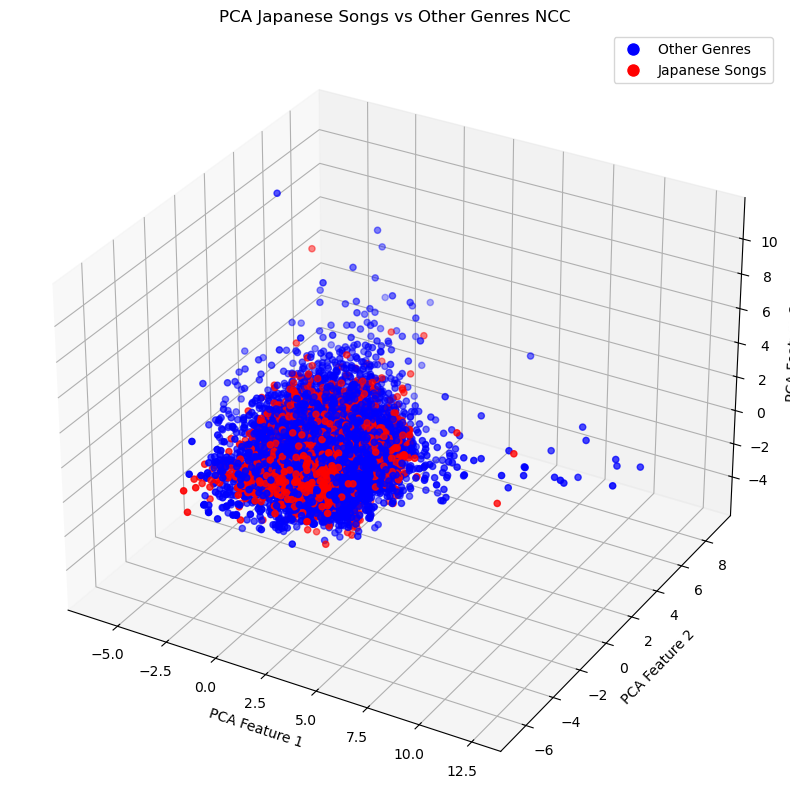

In [58]:
# Assuming 'pca_df' is a DataFrame with PCA components and 'outliers' column as labels
labels = pca_df_NCC['class']

# Create the 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data
scatter = ax.scatter(pca_df_NCC[0], pca_df_NCC[1], pca_df_NCC[2], c=labels, cmap='bwr', s=20)

# Set the title and labels
ax.set_title('PCA Japanese Songs vs Other Genres NCC')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')

# Create a legend
normal = plt.Line2D([0], [0], marker='o', color='w', label='Other Genres',
                    markerfacecolor='b', markersize=10)
outlier = plt.Line2D([0], [0], marker='o', color='w', label='Japanese Songs',
                     markerfacecolor='r', markersize=10)
ax.legend(handles=[normal, outlier])

# Show the plot
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     25324
           1       0.15      0.51      0.23      1076

    accuracy                           0.86     26400
   macro avg       0.56      0.69      0.57     26400
weighted avg       0.94      0.86      0.89     26400



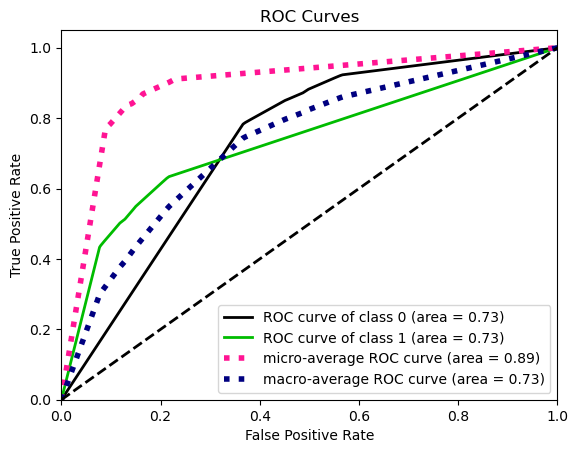

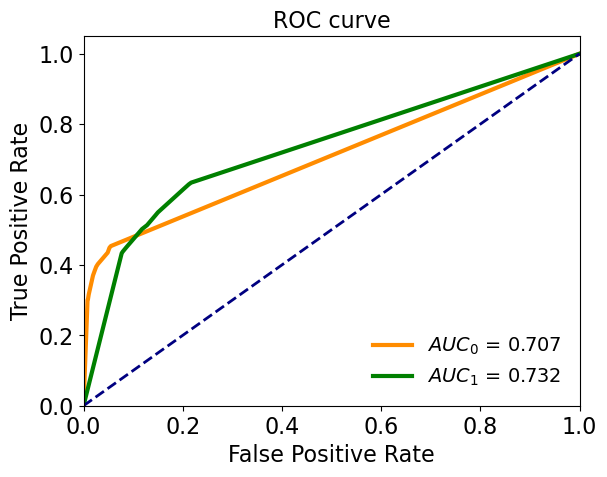

In [59]:
# fit
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res_CNN, y_res_CNN)

# predict
y_pred_CNN= clf.predict(X_test)
print(classification_report(y_test, y_pred_CNN))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

In [60]:
# Define the parameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],  # Split quality criterion
    'splitter': ['best', 'random'],    # Strategy used to split at each node
    'max_depth': [None] + list(np.arange(1, 20)),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 20),   # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Assuming X_res and y_res are already defined
# Fit the random search model
random_search.fit(X_res_CNN, y_res_CNN)

# Print the best parameters found by the random search
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}


In [ ]:
## clf = DecisionTreeClassifier(
    splitter = 'best',
    min_samples_split=7, 
    min_samples_leaf=9, 
    max_features=None, 
    max_depth=10, 
    criterion='entropy',
)
clf.fit(X_res_CNN, y_res_CNN)

# predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr, tpr)

#### Ensemble

C:\Users\marco\anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\marco\anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Accuracy 0.8210227272727273
F1-score [0.89806485 0.26710098]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     25324
           1       0.16      0.80      0.27      1076

    accuracy                           0.82     26400
   macro avg       0.58      0.81      0.58     26400
weighted avg       0.96      0.82      0.87     26400



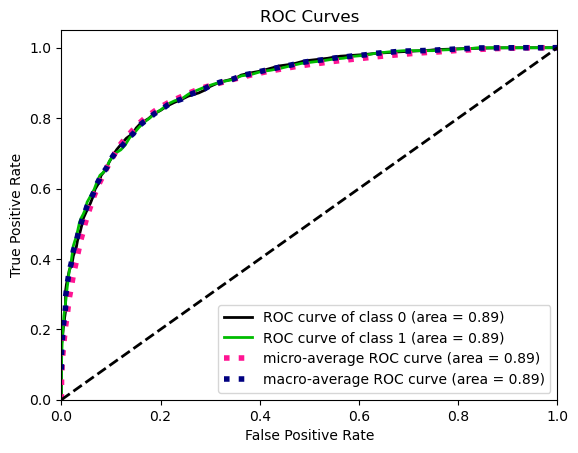

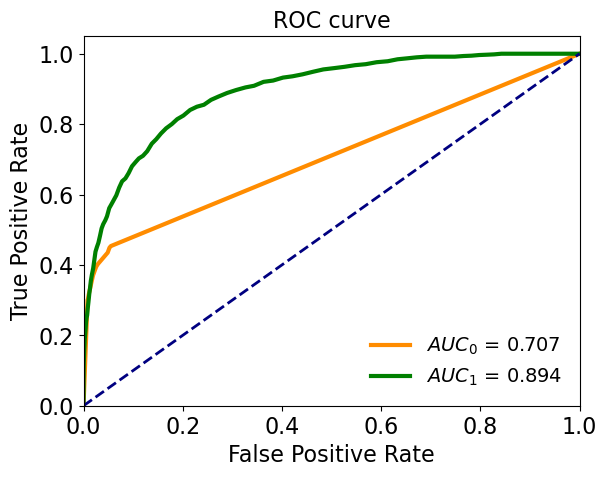

In [22]:
# Initialize Balanced Random Forest with default parameters
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_res, y_res)

# predict
y_pred = brf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# roc
y_score = brf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
plot_ROC_comparison(fpr,tpr)

The model identified correctly 80% of the records belong to class 1, but the precision is low due to the erroneous prediction of elements belonging to class 0 as 1. 